## INF8245E (Fall 2021) : Machine Learning - Assignment 2
## Amine EL AMERI - Matricule: 2164634

In [1]:
# this notebook has only been tested on jupyter locally

In [2]:
import numpy as np
from numpy.linalg import inv, pinv
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import mode
plt.rcParams['figure.figsize'] = [25, 6]

## 1 Linear Classification and Nearest Neighbor Classification

In [3]:
myPath = "Datasets/"
from os import listdir
from os.path import isfile, join
files = [(myPath + f) for f in listdir(myPath) if isfile(join(myPath, f))]
files

['Datasets/DS1_Cov.txt',
 'Datasets/DS1_m_0.txt',
 'Datasets/DS1_m_1.txt',
 'Datasets/DS2_c1_m1.txt',
 'Datasets/DS2_c1_m2.txt',
 'Datasets/DS2_c1_m3.txt',
 'Datasets/DS2_c2_m1.txt',
 'Datasets/DS2_c2_m2.txt',
 'Datasets/DS2_c2_m3.txt',
 'Datasets/DS2_Cov1.txt',
 'Datasets/DS2_Cov2.txt',
 'Datasets/DS2_Cov3.txt']

##### Q1

In [4]:
m0 = pd.read_csv('Datasets/DS1_m_0.txt', header=None)
m0 = m0.values.tolist()[0][:-1]

m1 = pd.read_csv('Datasets/DS1_m_1.txt', header=None)
m1 = m1.values.tolist()[0][:-1]

cov_mat = pd.read_csv('Datasets/DS1_Cov.txt', header=None)
cov_mat.drop(20, axis=1, inplace=True)
cov_mat = np.array(cov_mat.values.tolist())

In [5]:
# Generating two classes with 20 features each
class0 = np.random.multivariate_normal(m0, cov_mat, 2000)
class1 = np.random.multivariate_normal(m1, cov_mat, 2000)

# Labeling the data
class0 = np.c_[class0, -np.ones(2000)]
class1 = np.c_[class1, np.ones(2000)]

In [6]:
# shuffling the data so that we pick randomly
np.random.shuffle(class0)
np.random.shuffle(class1)

DS1_test = np.concatenate((class0[:400][:], class1[:400][:]), axis=0)
DS1_valid = np.concatenate((class0[400:800][:], class1[400:800][:]), axis=0)
DS1_train = np.concatenate((class0[800:][:], class1[800:][:]), axis=0)

np.random.shuffle(DS1_test)
np.random.shuffle(DS1_valid)
np.random.shuffle(DS1_train)

print(f"shapes of DS1 train, valid and test: {DS1_train.shape} {DS1_valid.shape} {DS1_test.shape}")

shapes of DS1 train, valid and test: (2400, 21) (800, 21) (800, 21)


In [7]:
# saving train, valid and test data as txt files
np.savetxt("DS1_train.txt", np.round(DS1_train, 3), fmt="%f", delimiter=",")
np.savetxt("DS1_valid.txt", np.round(DS1_valid, 3), fmt="%f", delimiter=",")
np.savetxt("DS1_test.txt", np.round(DS1_test, 3), fmt="%f", delimiter=",")

##### Q2

In [8]:
def GDA_estimate_param(DS1_data):
    N = DS1_data.shape[0]
    N1 = DS1_data[DS1_data[:,-1] == 1].shape[0] # select rows where last column is equal to 1
    N2 = DS1_data[DS1_data[:,-1] == -1].shape[0] # select rows where last column is equal to -1
    P_C1 = N1/N
    P_C2 = N2/N
    mu_1 = (1/N1) * np.delete(np.sum(DS1_data*DS1_data[:,-1][np.newaxis].T, axis=0), -1)
    mu_2 = (1/N2) * np.delete(np.sum(DS1_data*(1-DS1_data[:,-1])[np.newaxis].T, axis=0), -1)
    S1 = np.matmul((DS1_data[DS1_data[:,-1] == 1][:,:-1] - mu_1).T, (DS1_data[DS1_data[:,-1] == 1][:,:-1] - mu_1))
    S2 = np.matmul((DS1_data[DS1_data[:,-1] == -1][:,:-1] - mu_2).T, (DS1_data[DS1_data[:,-1] == -1][:,:-1] - mu_2))
    SIGMA = (S1 + S2)/N
    
    W = np.matmul(inv(SIGMA), (mu_1.T - mu_2.T))
    W0 = (-1/2)*np.matmul(np.matmul(mu_1,inv(SIGMA)), mu_1.T) + (1/2)*np.matmul(np.matmul(mu_2,inv(SIGMA)), mu_2.T) + np.log(P_C1/P_C2) 
    #return P_C1, P_C2, mu_1, mu_2, SIGMA
    return W, W0

In [9]:
W, W0 = GDA_estimate_param(DS1_train)
print(f"W = {W}")
print(f"W_0 = {W0}")

W = [ 1.0151873  -0.5363926  -0.0446655   0.12513376 -0.45602018 -0.30740899
  0.26024998 -1.87360453 -1.6297884   0.80806971 -0.97372003 -0.30168416
  0.66608189  0.5145918  -0.47116347  1.03467268  1.40055078 -0.55966081
  0.67470175 -0.41124149]
W_0 = 1.7616585456152754


In [10]:
def inferenceGDA(W, W0, DS_data):
    N = DS_data.shape[0]
    accuracy = 0
    for i in range(N):
        P_C1_x = 1/(1 + np.exp(np.matmul(W[np.newaxis], DS_data[i, :-1])[0] + W0))
        if (P_C1_x >= 0.5 and int(DS_data[i, -1]) == 1) or (P_C1_x < 0.5 and int(DS_data[i, -1]) == -1):
            accuracy += 1
    accuracy /= N
    return accuracy

In [11]:
inferenceGDA(W, W0, DS1_test)

0.84375

##### Q3

In [12]:
def knn_classifier(DS_train, DS_new_data, k):
    N_train = DS_train.shape[0]
    N_new_data = DS_new_data.shape[0]
    accuracy = 0
    for i in range(N_new_data):
        distance_all_elements = np.sum((DS_train[:, :-1] - DS_new_data[i, :-1])**2, axis=1)
        indexes_knn = np.argpartition(distance_all_elements, k)[:k]
        if np.sum(DS_train[indexes_knn, -1]) >= 0:
            predicted_class = 1 
        else:
            predicted_class = -1
            
        if predicted_class == int(DS_new_data[i, -1]): 
            accuracy += 1
            
    accuracy /= N_new_data
    return accuracy

In [73]:
def choose_best_k_and_test(DS_train, DS_valid, DS_test):

    accuracies = []
    ks = []

    for k in range(1, DS_train.shape[0], 5):
        accuracies.append(knn_classifier(DS_train, DS_valid, k))
        ks.append(k)
    plt.plot(ks, accuracies)
    plt.xlabel("k")
    plt.ylabel("validation accuracy")
    plt.show
    
    best_k = ks[np.argmax(accuracies)]
    print(f"the testing set accuracy with the best k, (k = {best_k}) is {knn_classifier(DS_train, DS_test, best_k)}") 

the testing set accuracy with the best k, (k = 91) is 0.55875


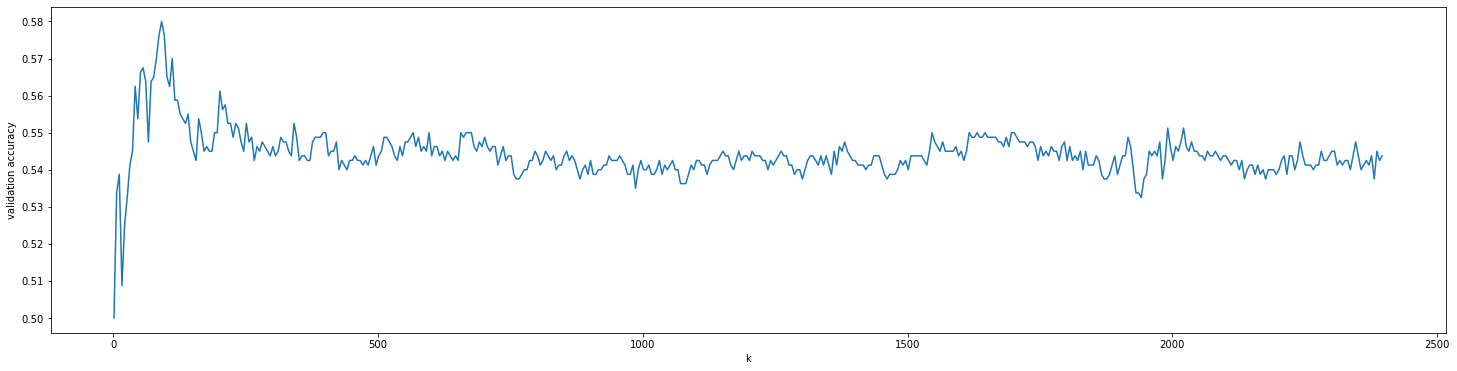

In [74]:
choose_best_k_and_test(DS1_train, DS1_valid, DS1_test)

##### Q4

In [15]:
# reading the data
c1_m1 = pd.read_csv('Datasets/DS2_c1_m1.txt', header=None)
c1_m1 = c1_m1.values.tolist()[0][:-1]

c1_m2 = pd.read_csv('Datasets/DS2_c1_m2.txt', header=None)
c1_m2 = c1_m2.values.tolist()[0][:-1]

c1_m3 = pd.read_csv('Datasets/DS2_c1_m3.txt', header=None)
c1_m3 = c1_m3.values.tolist()[0][:-1]

c2_m1 = pd.read_csv('Datasets/DS2_c2_m1.txt', header=None)
c2_m1 = c2_m1.values.tolist()[0][:-1]

c2_m2 = pd.read_csv('Datasets/DS2_c2_m2.txt', header=None)
c2_m2 = c2_m2.values.tolist()[0][:-1]

c2_m3 = pd.read_csv('Datasets/DS2_c2_m3.txt', header=None)
c2_m3 = c2_m3.values.tolist()[0][:-1]


cov1 = pd.read_csv('Datasets/DS2_Cov1.txt', header=None)
cov1.drop(20, axis=1, inplace=True)
cov1 = np.array(cov1.values.tolist())

cov2 = pd.read_csv('Datasets/DS2_Cov2.txt', header=None)
cov2.drop(20, axis=1, inplace=True)
cov2 = np.array(cov2.values.tolist())

cov3 = pd.read_csv('Datasets/DS2_Cov3.txt', header=None)
cov3.drop(20, axis=1, inplace=True)
cov3 = np.array(cov3.values.tolist())

In [16]:
# generating the data
DS2_class0 = np.array((1,1))
DS2_class1 = np.array((1,1))

while DS2_class0.shape[0] < 2000:
    gauss1_c0 = np.random.multivariate_normal(c1_m1, cov1, np.random.multinomial(2000, [0.10, 0.42, 0.48])[0]) 
    gauss2_c0 = np.random.multivariate_normal(c1_m2, cov2, np.random.multinomial(2000, [0.10, 0.42, 0.48])[1])  
    gauss3_c0 = np.random.multivariate_normal(c1_m3, cov3, np.random.multinomial(2000, [0.10, 0.42, 0.48])[2]) 
    DS2_class0 = np.append(np.append(gauss1_c0, gauss2_c0, axis=0), gauss3_c0, axis=0)
DS2_class0 = DS2_class0[:2000][:]

while DS2_class1.shape[0] < 2000:
    gauss1_c1 = np.random.multivariate_normal(c2_m1, cov1, np.random.multinomial(2000, [0.10, 0.42, 0.48])[0]) 
    gauss2_c1 = np.random.multivariate_normal(c2_m2, cov2, np.random.multinomial(2000, [0.10, 0.42, 0.48])[1])  
    gauss3_c1 = np.random.multivariate_normal(c2_m3, cov3, np.random.multinomial(2000, [0.10, 0.42, 0.48])[2]) 
    DS2_class1 = np.append(np.append(gauss1_c1, gauss2_c1, axis=0), gauss3_c1, axis=0)
DS2_class1 = DS2_class1[:2000][:]

In [17]:
# labeling the data
DS2_class0 = np.c_[DS2_class0, np.ones(DS2_class0.shape[0])]
DS2_class1 = np.c_[DS2_class1, -np.ones(DS2_class1.shape[0])]

In [18]:
# shuffling the data so that we pick randomly
np.random.shuffle(DS2_class0)
np.random.shuffle(DS2_class1)

DS2_test = np.concatenate((DS2_class0[:400][:], DS2_class1[:400][:]), axis=0)
DS2_valid = np.concatenate((DS2_class0[400:800][:], DS2_class1[400:800][:]), axis=0)
DS2_train = np.concatenate((DS2_class0[800:][:], DS2_class1[800:][:]), axis=0)

np.random.shuffle(DS2_test)
np.random.shuffle(DS2_valid)
np.random.shuffle(DS2_train)

print(f"shapes of DS2 train, valid and test: {DS2_train.shape} {DS2_valid.shape} {DS2_test.shape}")

shapes of DS2 train, valid and test: (2400, 21) (800, 21) (800, 21)


In [19]:
# saving train, valid and test data as txt files
np.savetxt("DS2_train.txt", np.round(DS2_train, 3), fmt="%f", delimiter=",")
np.savetxt("DS2_valid.txt", np.round(DS2_valid, 3), fmt="%f", delimiter=",")
np.savetxt("DS2_test.txt", np.round(DS2_test, 3), fmt="%f", delimiter=",")

##### Q5

In [63]:
W_DS2, W0_DS2 = GDA_estimate_param(DS2_train)
print(f"W (DS2) = {W_DS2}")
print(f"W_0 (DS2) = {W0_DS2}")

W (DS2) = [ 0.22655101  0.01416807  0.04487186  0.01264898 -0.35058712  0.00850368
  0.30804466 -0.20957603 -0.25992249 -0.11718761 -0.3028806  -0.16935253
 -0.26262091 -0.01955056  0.38374957 -0.03190767  0.05291551 -0.01642507
  0.25561316 -0.09770199]
W_0 (DS2) = 0.6058740228202765


In [64]:
inferenceGDA(W_DS2, W0_DS2, DS2_test)

0.51625

the testing set accuracy with the best k, (k = 6) is 0.5325


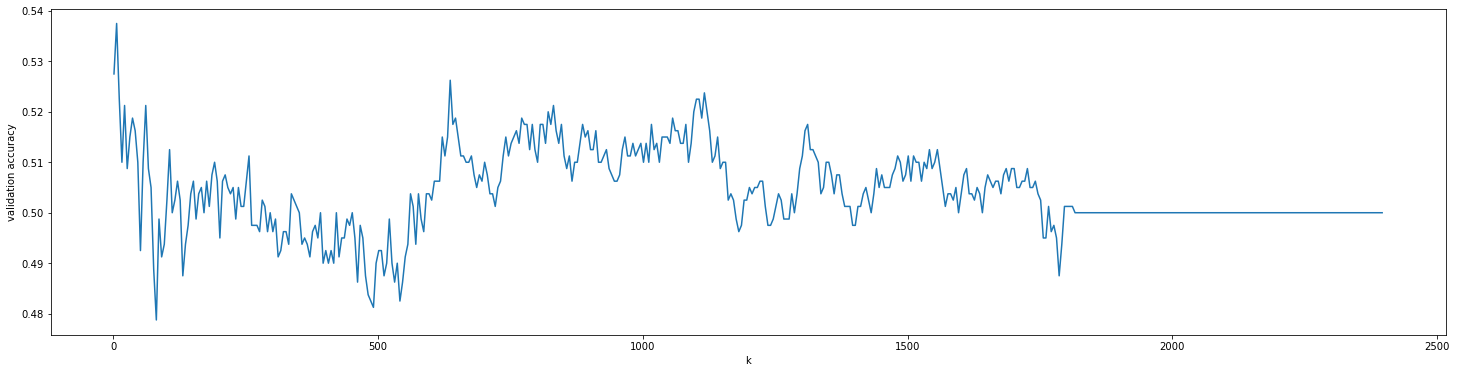

In [75]:
# KNN
choose_best_k_and_test(DS2_train, DS2_valid, DS2_test)

## 2 MNIST Handwritten Digits Classification

In [22]:
!pip install --user tensorflow

In [23]:
#Import Keras
from tensorflow import keras
# Loading the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [24]:
# Splitting train set to train and valid set
x_valid, y_valid = x_train[50000:][:][:], y_train[50000:]
x_train, y_train = x_train[:50000][:][:], y_train[:50000]

In [25]:
# flattening the data
x_train = np.array(x_train.reshape([-1, 784]), dtype=np.float64)
x_valid = np.array(x_valid.reshape([-1, 784]), dtype=np.float64)
x_test = np.array(x_test.reshape([-1, 784]), dtype=np.float64)

In [26]:
# normalizing
x_train, x_valid, x_test = x_train/255, x_valid/255, x_test/255

##### Q1

In [27]:
def GNB_estimate_param(x_train, y_train):
    
    # prior probabilities
    classes_train, occurences_train = np.unique(y_train, return_counts=True)
    prior_probas = occurences_train/len(y_train)
    
    nbr_classes = len(classes_train)
    
    # means and standard deviations, (with smoothing)
    mus = np.zeros((nbr_classes, x_train.shape[1]), dtype=np.float64)
    std_dvs = np.zeros((nbr_classes, x_train.shape[1]), dtype=np.float64)
    
    for k, _ in enumerate(np.unique(y_train)):
        idxs = np.where(y_train == k)
        mus[k] = np.mean(x_train[idxs], axis=0)
        std_dvs[k] = np.std(x_train[idxs], axis=0) + np.full_like(std_dvs[k], 1.0e-01, dtype=np.float64)
        
    return nbr_classes, prior_probas, mus, std_dvs

In [28]:
nbr_classes, prior_probas, mus, std_dvs = GNB_estimate_param(x_train, y_train)

In [29]:
def inferenceGNB(x_test, y_test, nbr_classes, prior_probas, mus, std_dvs):
    
    # predictions
    predictions = np.zeros((x_test.shape[0]), dtype=np.float64)
    
    for i in range(x_test.shape[0]):
        predictions[i] = np.argmax([np.log(prior_probas[k]) -( np.sum(np.log(std_dvs[k])) +  np.sum(((x_test[i]-mus[k])/std_dvs[k])**2) ).reshape(-1, 1) for k in range(nbr_classes)])
    
    # accuracy
    accuracy_GNB = 0
    for i in range(len(predictions)):
        if int(predictions[i]) == y_test[i]:
            accuracy_GNB += 1
    accuracy_GNB /= len(predictions)
    print(f"The accuracy of the GNB model is {accuracy_GNB}")
    
    return predictions, accuracy_GNB

In [30]:
predictions, accuracy_GNB = inferenceGNB(x_valid, y_valid, nbr_classes, prior_probas, mus, std_dvs)

The accuracy of the GNB model is 0.8139


##### Q2

In [60]:
def knn_classifier_mnist_test(x_train, y_train, x_test, y_test, k):
    
    N_test = x_test.shape[0]
    accuracy = 0
    for i in range(N_test):
        
        distance_all_elements = (x_train - x_test[i,:])
        distances_L2 = np.einsum('ij, ij->i', distance_all_elements, distance_all_elements)
        knns = y_train[np.argsort(distances_L2)[:k]]
        predicted_class = mode(knns)[0][0]
        
        if predicted_class == y_test[i]: 
            accuracy += 1
            
    accuracy /= N_test
    return accuracy

In [62]:
accuracies_knn_mnist = []
for i in [50, 500, 1300]:
    accuracies_knn_mnist.append(knn_classifier_mnist_test(x_train, y_train, x_valid, y_valid, i))

print(f"The validation accuracies for k in {[50, 500, 1300]} are {accuracies_knn_mnist}")

The validation accuracies for k in [50, 500, 1300] are [0.9518, 0.9047, 0.8579]


In [61]:
knn_classifier_mnist_test(x_train, y_train, x_test, y_test, 5)

0.9664